In [1]:
from apps.onedimensional.burgers import burgers
from apps.onedimensional.burgers.riemannexample import riemann_example
from pydogpack import main
from pydogpack.tests.utils import utils
from pydogpack.utils import dg_utils
from pydogpack.utils import math_utils
from pydogpack.utils import x_functions
from pydogpack.visualize import plot

from IPython.display import HTML

# Riemann Burgers Example

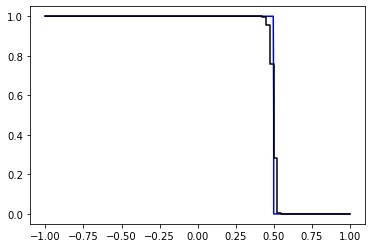

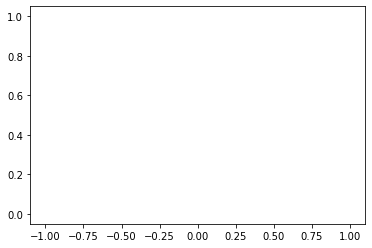

In [2]:
left_state = 1.0
right_state = 0.0
discontinuity_location = -0.5
problem = riemann_example.RiemannExample(left_state, right_state, discontinuity_location)
time_final = 2.0
problem.parameters["time_final"] = time_final
problem.parameters["is_weak"] = True

space_time_order = 1
problem.parameters["time_stepping"]["time_stepping_class"] = "explicit_runge_kutta"
problem.parameters["time_stepping"]["is_verbose"] = False
problem.parameters["time_stepping"]["order"] = space_time_order

num_elems = 80
x_left = -1.0
x_right = 1.0
problem.parameters["mesh"]["mesh_class"] = "mesh_1d_uniform"
problem.parameters["mesh"]["x_left"] = x_left
problem.parameters["mesh"]["x_right"] = x_right
problem.parameters["mesh"]["num_elems"] = num_elems

problem.parameters["basis"]["basis_class"] = "legendre"
problem.parameters["basis"]["inner_product_constant"] = 0.5
problem.parameters["basis"]["num_basis_cpts"] = space_time_order

problem.parameters["boundary_condition"]["boundary_condition_class"] = "extrapolation"
problem.parameters["riemann_solver"]["riemann_solver_class"] = "local_lax_friedrichs"

#cfl = dg_utils.standard_cfls(space_time_order)
cfl = 0.5
problem.parameters["delta_t"] = float(dg_utils.get_delta_t(cfl, problem.max_wavespeed, (x_right - x_left) / num_elems))

problem._setup_objects()

final_solution = main.run(problem)
exact_final_solution = x_functions.FrozenT(problem.exact_solution, time_final)
p = plot.create_plot_dg(final_solution, exact_final_solution)
ani, fig = plot.create_animation_output_dir(problem.output_dir, problem.exact_solution)
HTML(ani.to_html5_video())

In [29]:
problem.max_wavespeed

0.5

# Convergence Test

## DG Convergence

In [11]:
left_state = 1.0
right_state = 0.0
discontinuity_location = -0.5
problem = riemann_example.RiemannExample(left_state, right_state, discontinuity_location)
time_final = 2.0
exact_final_solution = x_functions.FrozenT(problem.exact_solution, time_final)

problem.parameters["time_final"] = time_final
problem.parameters["is_weak"] = True

problem.parameters["basis"]["basis_class"] = "legendre"
problem.parameters["basis"]["inner_product_constant"] = 0.5

problem.parameters["time_stepping"]["time_stepping_class"] = "explicit_runge_kutta"
problem.parameters["time_stepping"]["is_verbose"] = False

x_left = -1.0
x_right = 1.0
problem.parameters["mesh"]["mesh_class"] = "mesh_1d_uniform"
problem.parameters["mesh"]["x_left"] = x_left
problem.parameters["mesh"]["x_right"] = x_right

problem.parameters["boundary_condition"]["boundary_condition_class"] = "extrapolation"
problem.parameters["riemann_solver"]["riemann_solver_class"] = "local_lax_friedrichs"

In [14]:
for num_basis_cpts in range(1,2):
    problem.parameters["basis"]["num_basis_cpts"] = num_basis_cpts
    problem.parameters["time_stepping"]["order"] = num_basis_cpts
    
    cfl = 0.5
    error_list = []
    for num_elems in [80, 160]:
        problem.parameters["delta_t"] = float(dg_utils.get_delta_t(cfl, problem.max_wavespeed, (x_right - x_left) / num_elems))
        problem.parameters["mesh"]["num_elems"] = num_elems
        final_solution = main.run(problem)
        error = math_utils.compute_error(final_solution, exact_final_solution)
        error_list.append(error)
    order = utils.convergence_order(error_list)
    print(order)
    print(error_list)
    if error_list[-1] >= math_utils.MACHINE_ERROR:
        assert order >= num_basis_cpts

0.0
[0.04859539563624901, 0.03436906201972776]


AssertionError: 

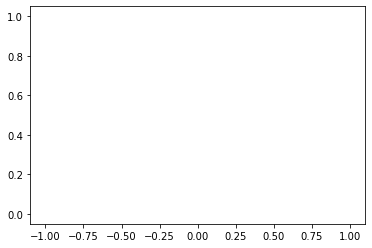

In [16]:
ani, fig = plot.create_animation_output_dir(problem.output_dir, problem.exact_solution)
HTML(ani.to_html5_video())

## FV Convergence

In [27]:
wavespeed = 1.0
left_state = 1.0
right_state = -1.0
discontinuity_location = -0.5
problem = riemann_scalar_example.RiemannScalarExample(wavespeed, left_state, right_state, discontinuity_location)
time_final = 1.0
exact_solution = problem.exact_solution
exact_final_solution = x_functions.FrozenT(exact_solution, time_final)

problem.parameters["time_final"] = time_final
problem.parameters["is_weak"] = True
problem.parameters["use_wave_propogation_method"] = True

problem.parameters["basis"]["basis_class"] = "finite_volume"

problem.parameters["time_stepping"]["time_stepping_class"] = "explicit_runge_kutta"
problem.parameters["time_stepping"]["order"] = 1
problem.parameters["time_stepping"]["is_verbose"] = False

x_left = -1.0
x_right = 1.0
problem.parameters["mesh"]["mesh_class"] = "mesh_1d_uniform"
problem.parameters["mesh"]["x_left"] = x_left
problem.parameters["mesh"]["x_right"] = x_right

problem.parameters["boundary_condition"]["boundary_condition_class"] = "extrapolation"
problem.parameters["fluctuation_solver"]["fluctuation_solver_class"] = "exact_linear"

In [30]:
cfl = dg_utils.standard_cfls(1)
error_list = []
for num_elems in [20, 40]:
    problem.parameters["delta_t"] = dg_utils.get_delta_t(cfl, wavespeed, (x_right - x_left) / num_elems)
    problem.parameters["mesh"]["num_elems"] = num_elems
    final_solution = main.run(problem)
    error = math_utils.compute_error(final_solution, exact_final_solution)
    error_list.append(error)
order = utils.convergence_order(error_list)
if error_list[-1] >= math_utils.MACHINE_ERROR:
    assert order >= 1
else:
    # This should in fact be exact, only machine error as exactly solving riemann problem
    print(error_list)

[9.930136612989089e-17, 1.299008383373379e-15]


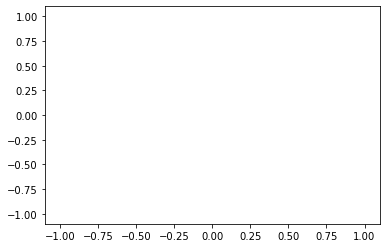

In [31]:
ani, fig = plot.create_animation_output_dir(problem.output_dir)
HTML(ani.to_html5_video())

# Shock Capturing Limiter Example

## Example - No limiting results in oscillations

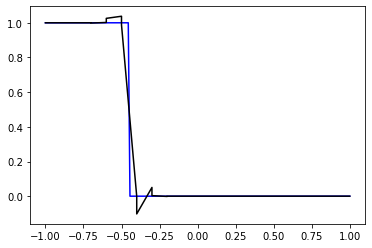

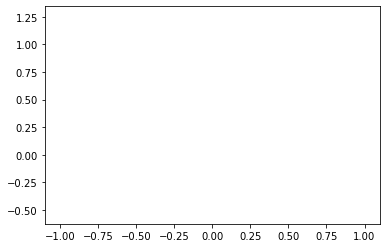

In [4]:
left_state = 1.0
right_state = 0.0
discontinuity_location = -0.5
problem = riemann_example.RiemannExample(left_state, right_state, discontinuity_location)
time_final = 0.1
problem.parameters["time_final"] = time_final
problem.parameters["is_weak"] = True

space_time_order = 2
problem.parameters["time_stepping"]["time_stepping_class"] = "explicit_runge_kutta"
problem.parameters["time_stepping"]["is_verbose"] = False
problem.parameters["time_stepping"]["num_frames"] = 2
problem.parameters["time_stepping"]["order"] = space_time_order

num_elems = 20
x_left = -1.0
x_right = 1.0
problem.parameters["mesh"]["mesh_class"] = "mesh_1d_uniform"
problem.parameters["mesh"]["x_left"] = x_left
problem.parameters["mesh"]["x_right"] = x_right
problem.parameters["mesh"]["num_elems"] = num_elems

problem.parameters["basis"]["basis_class"] = "legendre"
problem.parameters["basis"]["inner_product_constant"] = 0.5
problem.parameters["basis"]["num_basis_cpts"] = space_time_order

#problem.parameters["shock_capturing_limiter"]["shock_capturing_limiter_class"] = "bounds"
#problem.parameters["shock_capturing_limiter"]["bounds_alpha_value"] = 50

problem.parameters["boundary_condition"]["boundary_condition_class"] = "extrapolation"
problem.parameters["riemann_solver"]["riemann_solver_class"] = "local_lax_friedrichs"

cfl = dg_utils.standard_cfls(space_time_order)
#cfl = 0.5
#problem.parameters["delta_t"] = float(dg_utils.get_delta_t(cfl, problem.max_wavespeed, (x_right - x_left) / num_elems))
problem.parameters["delta_t"] = 0.05

problem._setup_objects()

final_solution = main.run(problem)
exact_final_solution = x_functions.FrozenT(problem.exact_solution, time_final)
p = plot.create_plot_dg(final_solution, exact_final_solution)
ani, fig = plot.create_animation_output_dir(problem.output_dir, problem.exact_solution)
HTML(ani.to_html5_video())

## Example - limiting stops oscillations

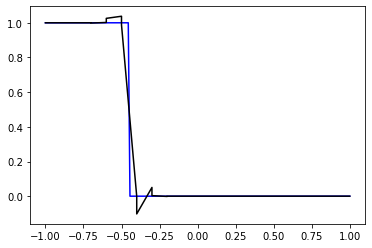

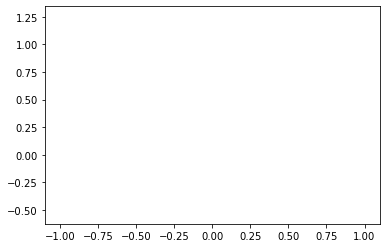

In [9]:
left_state = 1.0
right_state = 0.0
discontinuity_location = -0.5
problem = riemann_example.RiemannExample(left_state, right_state, discontinuity_location)
time_final = 0.1
problem.parameters["time_final"] = time_final
problem.parameters["is_weak"] = True

space_time_order = 2
problem.parameters["time_stepping"]["time_stepping_class"] = "explicit_runge_kutta"
problem.parameters["time_stepping"]["is_verbose"] = False
problem.parameters["time_stepping"]["num_frames"] = 2
problem.parameters["time_stepping"]["order"] = space_time_order

num_elems = 20
x_left = -1.0
x_right = 1.0
problem.parameters["mesh"]["mesh_class"] = "mesh_1d_uniform"
problem.parameters["mesh"]["x_left"] = x_left
problem.parameters["mesh"]["x_right"] = x_right
problem.parameters["mesh"]["num_elems"] = num_elems

problem.parameters["basis"]["basis_class"] = "legendre"
problem.parameters["basis"]["inner_product_constant"] = 0.5
problem.parameters["basis"]["num_basis_cpts"] = space_time_order

problem.parameters["shock_capturing_limiter"]["shock_capturing_limiter_class"] = "bounds"
problem.parameters["shock_capturing_limiter"]["bounds_alpha_value"] = 50

problem.parameters["boundary_condition"]["boundary_condition_class"] = "extrapolation"
problem.parameters["riemann_solver"]["riemann_solver_class"] = "local_lax_friedrichs"

cfl = dg_utils.standard_cfls(space_time_order)
#cfl = 0.5
problem.parameters["delta_t"] = float(dg_utils.get_delta_t(cfl, problem.max_wavespeed, (x_right - x_left) / num_elems))
#problem.parameters["delta_t"] = 0.05

problem._setup_objects()
problem.event_hooks = dg_utils.get_default_event_hooks(problem)

final_solution = main.run(problem)
exact_final_solution = x_functions.FrozenT(problem.exact_solution, time_final)
p = plot.create_plot_dg(final_solution, exact_final_solution)
ani, fig = plot.create_animation_output_dir(problem.output_dir, problem.exact_solution)
HTML(ani.to_html5_video())

In [12]:
problem.shock_capturing_limiter.variable_transformation

In [13]:
problem.event_hooks

{}

In [22]:
problem.parameters["delta_t"]

0.06